## Introduction

Note:
This notebook is an edited form of the tutorial by - [Keras](https://keras.io/examples/vision/siamese_network/)

A [Siamese Network](https://en.wikipedia.org/wiki/Siamese_neural_network) is a type of network architecture that
contains two or more identical subnetworks used to generate feature vectors for each input and compare them.

Siamese Networks can be applied to different use cases, like detecting duplicates, finding anomalies, and face recognition.

This example uses a Siamese Network with three identical subnetworks. We will provide three images to the model, where
two of them will be similar (_anchor_ and _positive_ samples), and the third will be unrelated (a _negative_ example.)
Our goal is for the model to learn to estimate the similarity between images.

For the network to learn, we use a triplet loss function. You can find an introduction to triplet loss in the
[FaceNet paper](https://arxiv.org/pdf/1503.03832.pdf) by Schroff et al,. 2015. In this example, we define the triplet
loss function as follows:

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`


## Setup

In [3]:
!pip install pytorch

  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch: started
    Running setup.py install for pytorch: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'D:\anaconda\envs\MaskRCNN\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\korea\\AppData\\Local\\Temp\\pip-install-1p1l2fzq\\pytorch_71b9eaacb5ab4d8b9fe2a139b7464b91\\setup.py'"'"'; __file__='"'"'C:\\Users\\korea\\AppData\\Local\\Temp\\pip-install-1p1l2fzq\\pytorch_71b9eaacb5ab4d8b9fe2a139b7464b91\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\korea\AppData\Local\Temp\pip-wheel-uly524xd'
       cwd: C:\Users\korea\AppData\Local\Temp\pip-install-1p1l2fzq\pytorch_71b9eaacb5ab4d8b9fe2a139b7464b91\
  Complete output (5 lines):
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\korea\AppData\Loc

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path

from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import resnet, resnet_v2, ResNet50, ResNet50V2, EfficientNetB3, InceptionV3, InceptionResNetV2

ModuleNotFoundError: No module named 'tensorflow'

## Load the dataset


In [2]:
import os
import pandas as pd
embeddings_dir = "embeddings_train_data"
if not os.path.isdir(embeddings_dir):    
    from google.colab import drive
    drive.mount('/content/drive')
    !cp "/content/drive/MyDrive/Myntra/embeddings_train_data.zip" "/content/"
    !cp "/content/drive/MyDrive/Myntra/top_pairs.csv" "/content/"
    !cp "/content/drive/MyDrive/Myntra/bottom_pairs.csv" "/content/"
    !cp "/content/drive/MyDrive/Myntra/foot_pairs.csv" "/content/"
    !unzip "embeddings_train_data.zip" 
    !rm "embeddings_train_data.zip"
    print("Data Loaded Successfully!")
else:
    print("Data already loaded!")

Data already loaded!


## Preparing the data

We are going to use a `tf.data` pipeline to load the data and generate the triplets that we
need to train the Siamese network.

We'll set up the pipeline using a zipped list with anchor, positive, and negative filenames as
the source. The pipeline will load and preprocess the corresponding images.

In [3]:

def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, TARGET_SHAPE[:2])
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images,
    preprocess them.
    """
    return preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative)

def visualize(anchor, positive, negative, n=3):
    """Visualize triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(3*n, 9))

    axs = fig.subplots(n, 3)
    for i in range(n):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

## Setting up the embedding generator model

Our Siamese Network will generate embeddings for each of the images of the
triplet. To do this, we will use a ResNet50 model pretrained on ImageNet and
connect a few `Dense` layers to it so we can learn to separate these
embeddings.

We will unfreeze the weights of all the layers of the model.
This is important to learn upon the weights that the model has already learned since the amount of data we posses is sufficient to properly fine tune them to our needs

In [4]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
TARGET_SHAPE = (224, 224, 3)
EMBEDDING_DIMENSION = 256
EPOCHS = 100

In [5]:
tf.keras.backend.clear_session()

base_model = ResNet50(weights="imagenet", input_shape=TARGET_SHAPE, include_top=False)

for layer in base_model.layers:
    layer.trainable = True

x = Flatten()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)

output = Dense(EMBEDDING_DIMENSION, activation="linear")(x)

embedding = Model(base_model.input, output, name="Embedding")

## Setting up the Siamese Network model

The Siamese network will receive each of the triplet images as an input,
generate the embeddings, and output the distance between the anchor and the
positive embedding, as well as the distance between the anchor and the negative
embedding.

To compute the distance, we can use a custom layer `DistanceLayer` that
returns both values as a tuple.

In [6]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = Input(name="anchor", shape=TARGET_SHAPE)
positive_input = Input(name="positive", shape=TARGET_SHAPE)
negative_input = Input(name="negative", shape=TARGET_SHAPE)

distances = DistanceLayer()(embedding(resnet.preprocess_input(anchor_input)), embedding(resnet.preprocess_input(positive_input)), embedding(resnet.preprocess_input(negative_input)))

siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

## Putting everything together

We now need to implement a model with custom training loop so we can compute
the triplet loss using the three embeddings produced by the Siamese network.

Let's create a `Mean` metric instance to track the loss of the training process.

In [7]:

class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

Let's setup our data pipeline using a zipped list with an anchor, positive,
and negative image filename as the source. The output of the pipeline
contains the same triplet with every image loaded and preprocessed.

In [8]:
dataframe = pd.read_csv("foot_pairs.csv")
dataframe.negative.fillna(dataframe.negative.mode()[0], inplace=True)
for column in dataframe.columns:
    dataframe[column] = dataframe[column].apply(lambda x: x.replace("\\","/")) 

anchor_images = dataframe.anchor.to_list()
positive_images = dataframe.positive.to_list()
negative_images = dataframe.negative.to_list()
image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

Let's take a look at a few examples of triplets. Notice how the first two images
look alike while the third one is always different.

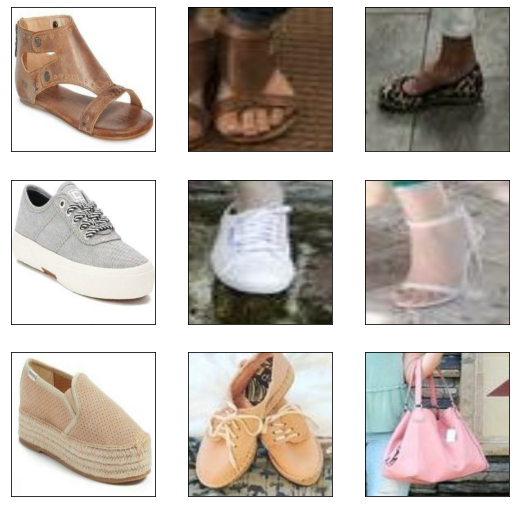

In [9]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## Training

We are now ready to train our model.

In [10]:
callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]

In [11]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(LEARNING_RATE))
siamese_model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/100
568/568 [==============================] - 670s 1s/step - loss: 0.4955 - val_loss: 0.4993
Epoch 2/100
568/568 [==============================] - 647s 1s/step - loss: 0.4889 - val_loss: 0.4950
Epoch 3/100
568/568 [==============================] - 644s 1s/step - loss: 0.4934 - val_loss: 0.4937
Epoch 4/100
568/568 [==============================] - 643s 1s/step - loss: 0.4879 - val_loss: 0.4991
Epoch 5/100
568/568 [==============================] - 640s 1s/step - loss: 0.4906 - val_loss: 0.4936
Epoch 6/100
568/568 [==============================] - 642s 1s/step - loss: 0.4963 - val_loss: 0.5000
Epoch 7/100
568/568 [==============================] - 641s 1s/step - loss: 0.4957 - val_loss: 0.4994
Epoch 8/100
568/568 [==============================] - 639s 1s/step - loss: 0.4799 - val_loss: 0.4806
Epoch 9/100
568/568 [==============================] - 638s 1s/step - loss: 0.4906 - val_loss: 0.4992
Epoch 10/100
568/568 [==============================] - 643s 1s/step - loss: 0.490

## Inspecting what the network has learned

At this point, we can check how the network learned to separate the embeddings
depending on whether they belong to similar images.

We can use Euclidean Distance to measure the
similarity between embeddings.

Let's pick a sample from the dataset to check the similarity between the
embeddings generated for each image.

In [12]:
sample = next(iter(train_dataset))
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (embedding(resnet.preprocess_input(anchor)), embedding(resnet.preprocess_input(positive)), embedding(resnet.preprocess_input(negative)),)

Finally, we can compute the cosine similarity between the anchor and positive
images and compare it with the similarity between the anchor and the negative
images.

We should expect the similarity between the anchor and positive images to be
larger than the similarity between the anchor and the negative images.

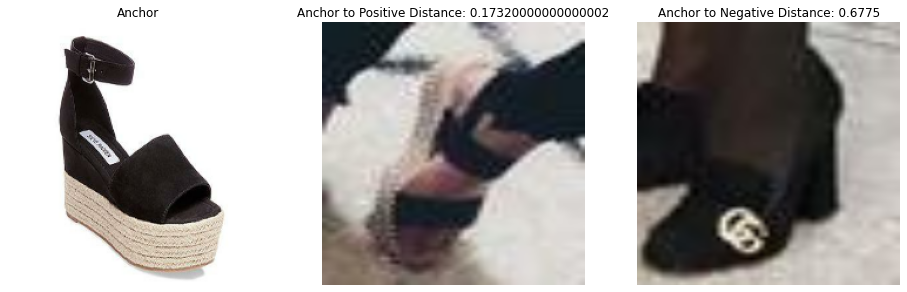

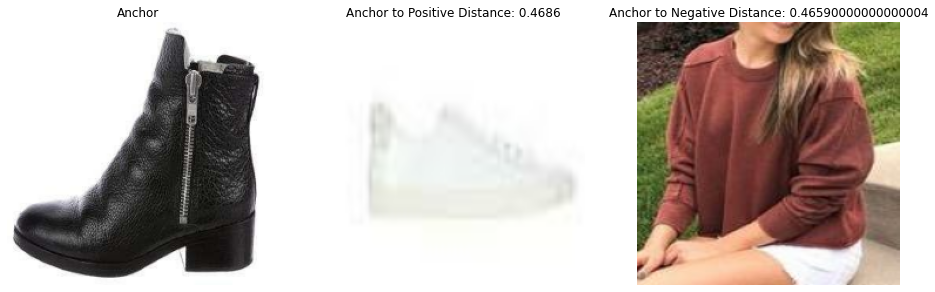

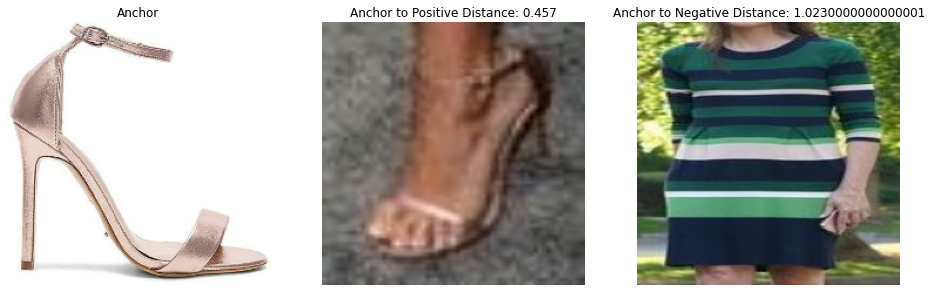

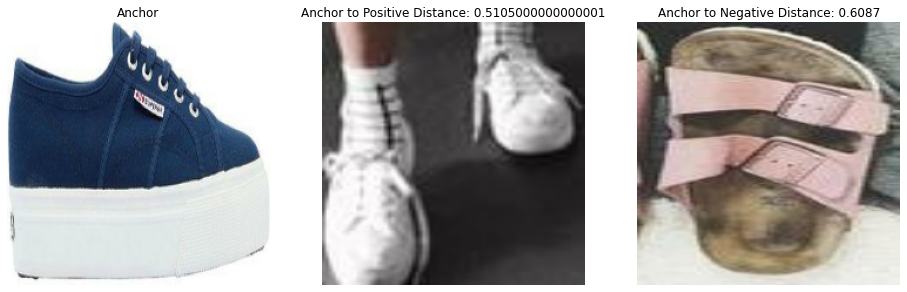

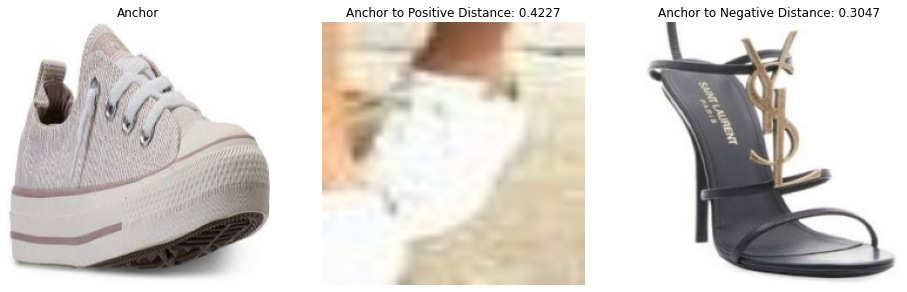

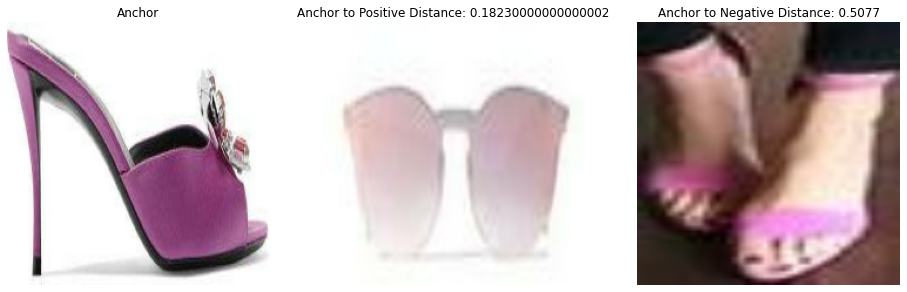

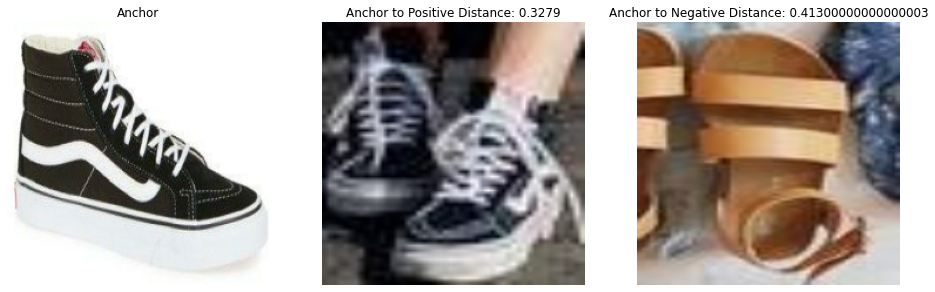

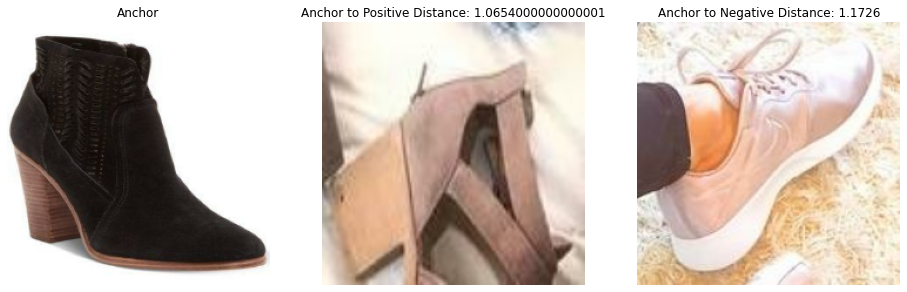

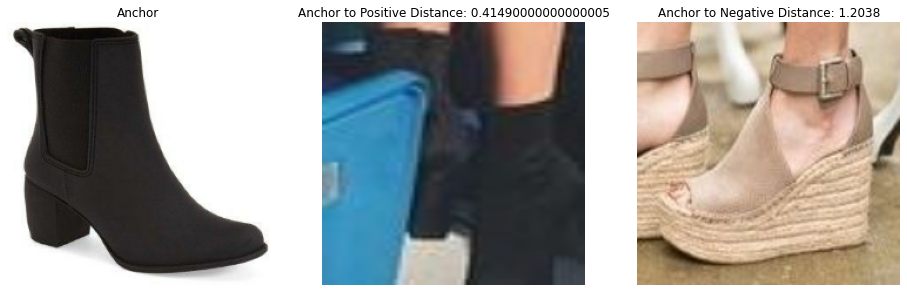

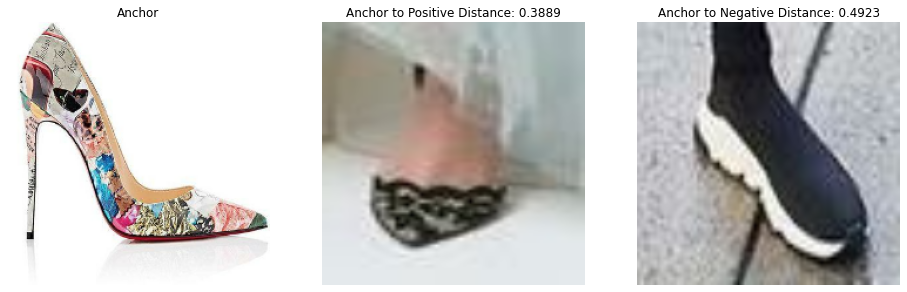

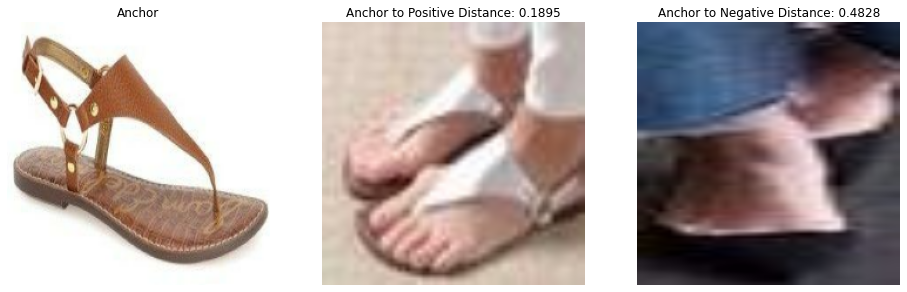

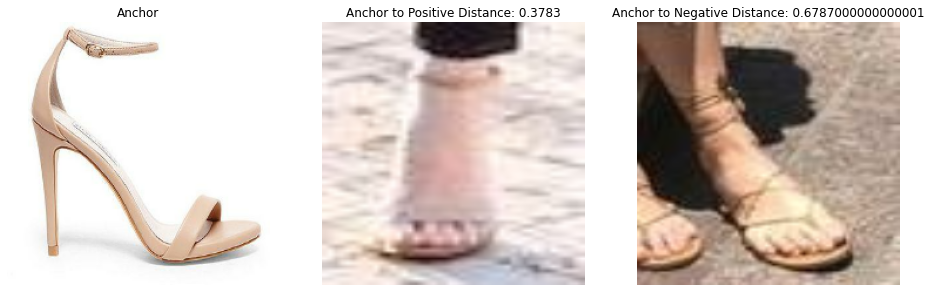

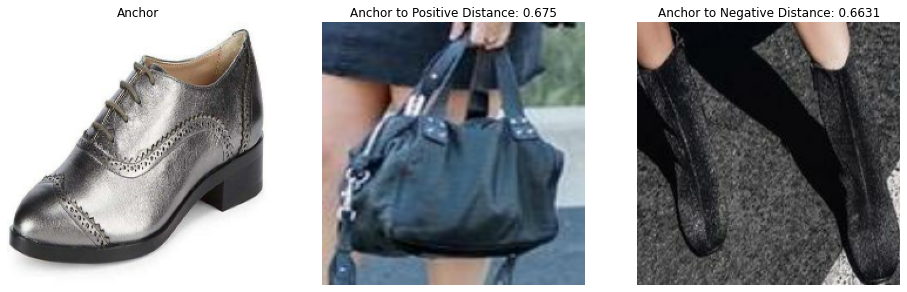

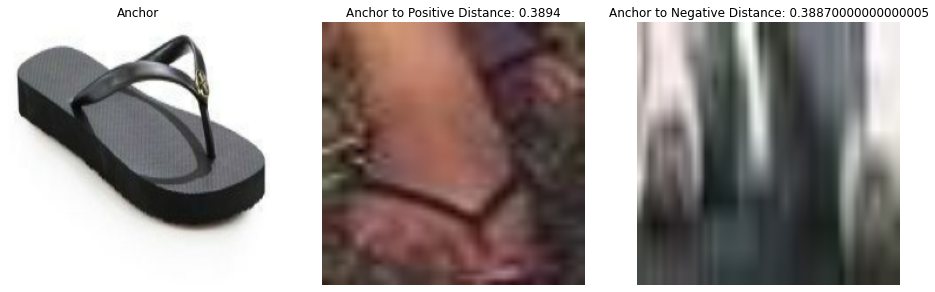

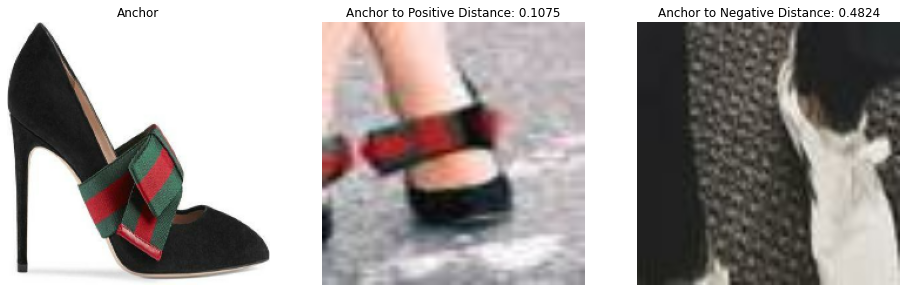

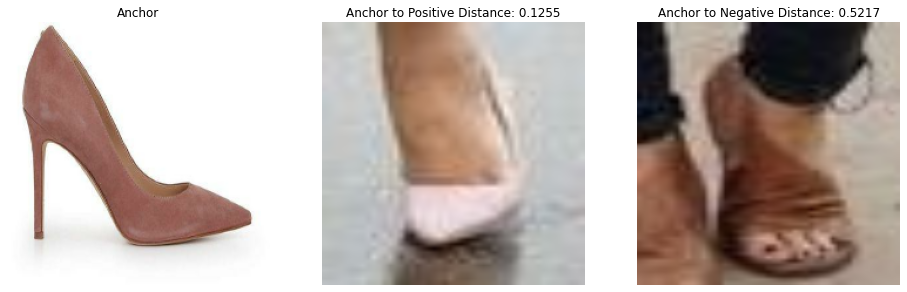

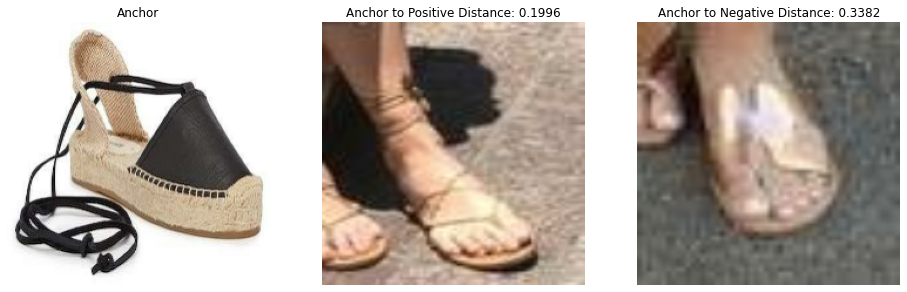

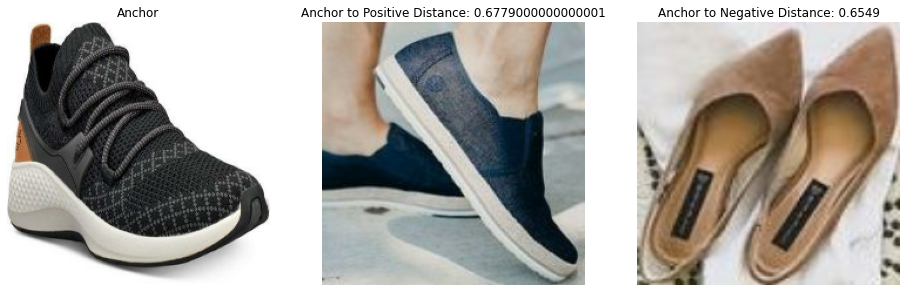

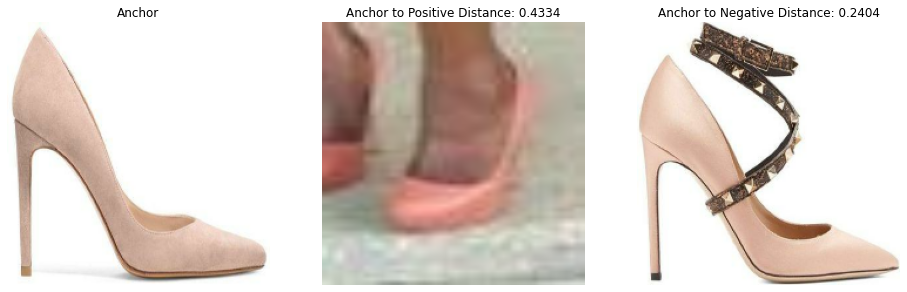

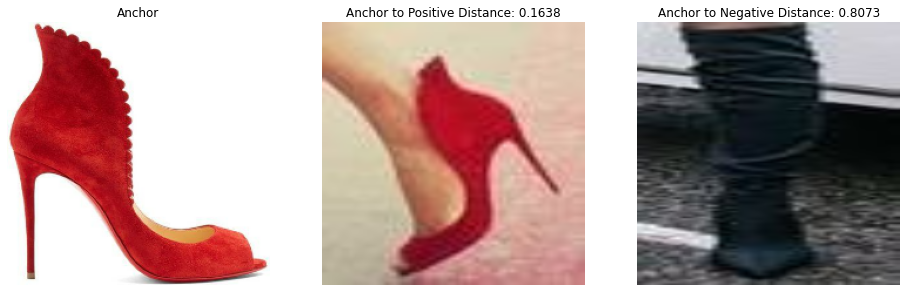

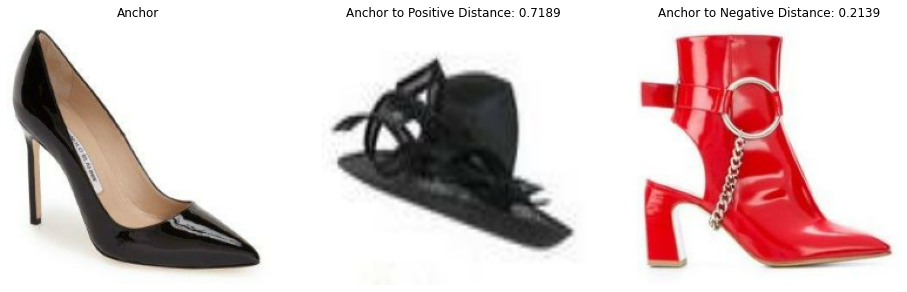

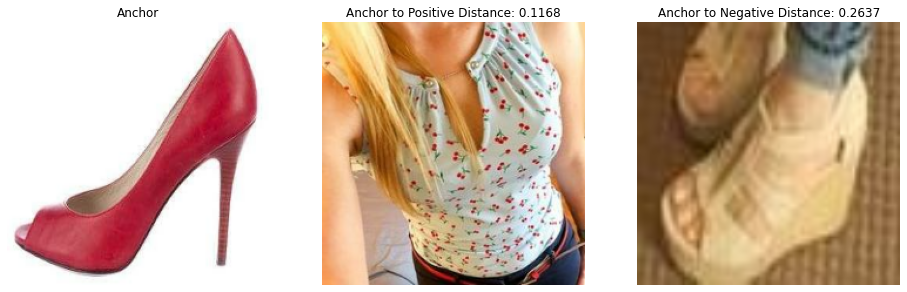

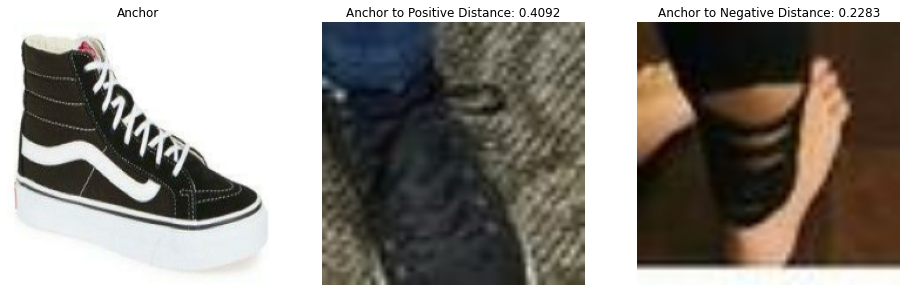

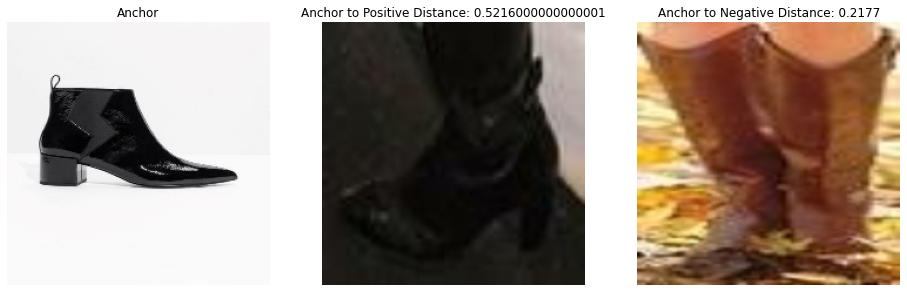

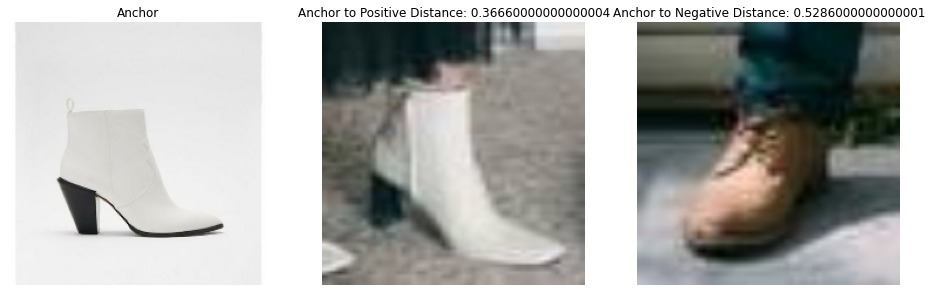

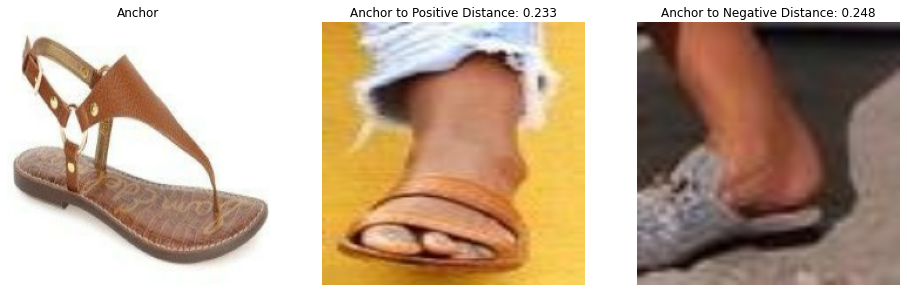

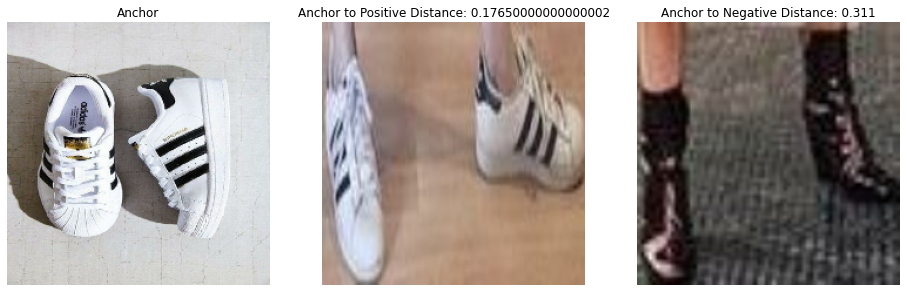

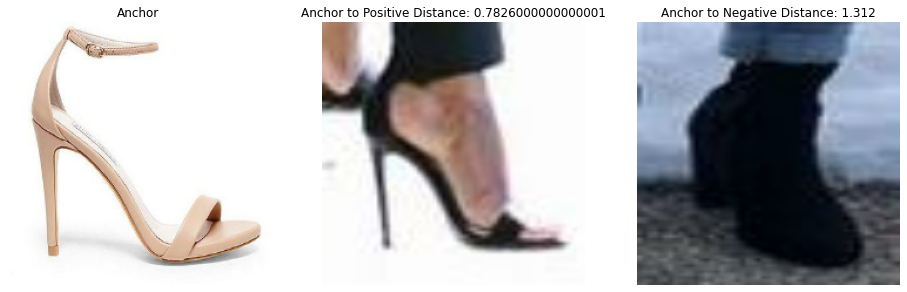

In [13]:
anchors, positives, negatives = sample
for i in range(len(anchor_embedding)):
    anchor, positive, negative = anchors[i], positives[i], negatives[i]
    positive_distance = np.linalg.norm(anchor_embedding[i] - positive_embedding[i], ord=2)*1e4
    negative_distance = np.linalg.norm(anchor_embedding[i] - negative_embedding[i], ord=2)*1e4
    positive_distance, negative_distance = round(positive_distance)*1e-4, round(negative_distance)*1e-4
    plt.figure(figsize=(16,9))
    plt.subplot(131)
    plt.imshow(anchor)
    plt.axis("off")
    plt.title("Anchor")
    plt.subplot(132)
    plt.imshow(positive)
    plt.axis("off")
    plt.title(f"Anchor to Positive Distance: {positive_distance}")
    plt.subplot(133)
    plt.imshow(negative)
    plt.axis("off")
    plt.title(f"Anchor to Negative Distance: {negative_distance}")
    plt.show()        

In [14]:
embedding.save("footwear_embedding.h5")

In [15]:
!cp footwear_embedding.h5 /content/drive/MyDrive/Myntra/